In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from manim import *

Manim Community v0.17.2

In [2]:
def get_correlated_dataset(n, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

In [3]:
def generate_on_line(n, a, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu

    x = scaled_with_offset[:, 0]
    y = scaled_with_offset[:, 1] + a * x

    return x, y

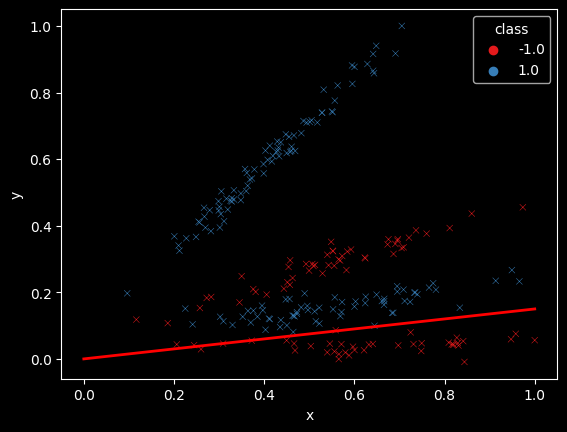

In [233]:
np.random.seed(0)

dependency = [[1.0, 0.0],
              [0.0, 1.0]]

mu = 10, 10
scale = 3, 5

data = {
    'x': [],
    'y': [],
    'class': [],
}

CLASS_A = 1.0
CLASS_B = -1.0

s = 2
# upper A
x, y = generate_on_line(40*s, 10, dependency, mu, scale)
data['x'].extend(0.5 * x)
data['y'].extend(y)
data['class'].extend([CLASS_A] * len(x))

# lower A
x, y = generate_on_line(33*s, 2, dependency, mu, scale)
data['x'].extend(0.7 * x)
data['y'].extend(y)
data['class'].extend([CLASS_A] * len(x))

# upper B
x, y = generate_on_line(25*s, 5, dependency, mu, scale)
data['x'].extend(0.7 * x)
data['y'].extend(0.95 * y)
data['class'].extend([CLASS_B] * len(x))

# lower B
x, y = generate_on_line(20*s, .1, dependency, mu, scale)
data['x'].extend(0.8 * x)
data['y'].extend(0.7 * y)
data['class'].extend([CLASS_B] * len(x))

df = pd.DataFrame(data)
df.x /= df.x.max()
df.y /= df.y.max()


sns.scatterplot(data=df, x='x', y='y',
                hue='class', s=20,
                marker='x', palette='Set1')

x = np.linspace(0, 1)
plt.plot(x, .15 * x, color='red', linewidth=2)

plt.show()

In [241]:
import torch

class LinearModelNoBias(torch.nn.Module):

     def __init__(self, input_dim, output_dim):
        super(LinearModelNoBias, self).__init__()
        self.weight = torch.nn.Parameter(torch.empty((input_dim, output_dim)))

     def forward(self, x):
         return self.weight * x
     
model = LinearModelNoBias(1, 1)
training_X = torch.tensor(df.x.to_numpy())
training_Y = torch.tensor(df.y.to_numpy())
training_targets = torch.tensor(df['class'].to_numpy())

mse = torch.nn.MSELoss()

def loss_fn(model, x, y, targets):
    # parameter to control scale and highlight local minima
    # high k gives more weight to close classifications  
    k = 7  
    return mse(torch.tanh(k * (y - model(x))).squeeze(), targets)


class LossLandscape:

    def __call__(self, w):#
        return self.forward(w).detach().numpy()
    
    def forward(self, w):
        model.load_state_dict({'weight': torch.tensor([[w]], requires_grad=True)})
        return loss_fn(model, training_X, training_Y, training_targets)

In [242]:
class SGDLossLandscape:

    def __init__(self, random_state=None):
        MINI_BATCH_SIZE = df.index.size // 2
        self.mini_df = df.sample(MINI_BATCH_SIZE, random_state=random_state)

    def forward(self, w):
        training_mini_X = torch.tensor(self.mini_df.x.to_numpy(), requires_grad=True)
        training_mini_Y = torch.tensor(self.mini_df.y.to_numpy(), requires_grad=True)
        training_mini_targets = torch.tensor(self.mini_df['class'].to_numpy(), requires_grad=True)
        model.load_state_dict({'weight': torch.tensor([[w]], requires_grad=True)})
        return loss_fn(model, training_mini_X, training_mini_Y, training_mini_targets)

    def __call__(self, w):
        return self.forward(w).detach().numpy()
    
    def grad(self, w):
        # return self.forward(w).backward()
        training_mini_X = torch.tensor(self.mini_df.x.to_numpy(), requires_grad=True)
        training_mini_Y = torch.tensor(self.mini_df.y.to_numpy(), requires_grad=True)
        training_mini_targets = torch.tensor(self.mini_df['class'].to_numpy(), requires_grad=True)
        # model.load_state_dict({'weight': torch.tensor([[w]], requires_grad=True)})
        model.load_state_dict({'weight': w})
        return loss_fn(model, training_mini_X, training_mini_Y, training_mini_targets)

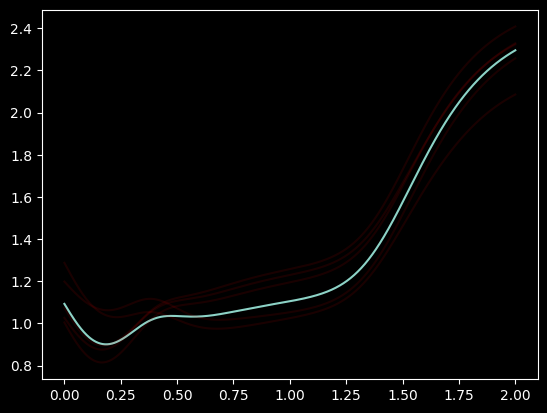

In [254]:
w = np.linspace(0, 2, 1000)
loss_landscape = np.vectorize(LossLandscape())

plt.plot(w, loss_landscape(w))
for _ in range(5):
    sgd_loss_landscape = np.vectorize(SGDLossLandscape())
    plt.plot(w, sgd_loss_landscape(w), alpha=0.1, c='red')

In [259]:
%%manim Animations


def lerp_fns(f1, f2, t):
    return np.vectorize(lambda x: (1 - t) * f1(x) + t * f2(x))


class Animations(Scene):

    def create_scatter_point(self, row):
        row_idx, data_point = row
        colour = self.get_colour(row)
        if colour == GREY:
            opacity = 0.25
        else:
            opacity = 1.0

        if data_point['class'] == 1:
            marker = Dot(color=colour, radius=self.marker_size, fill_opacity=opacity)
        else:
            dot = Dot(color=RED, radius=self.marker_size)
            marker = Cross(mobject=dot, color=colour, stroke_color=colour, 
                           stroke_width=self.marker_size * 50, stroke_opacity=opacity)
        
        marker.move_to(self.data_axes.coords_to_point(data_point.x, data_point.y))

        return marker

    def get_colour(self, row):
        row_idx, data_point = row

        t = self.t.get_value();
        if t > 0:
            loss_fn = self.next_loss_fn
        else:
            loss_fn = self.curr_loss_fn

        if data_point['class'] == 1:
            colour = RED
        else:
            colour = BLUE
        
        is_deactive = isinstance(loss_fn.pyfunc, SGDLossLandscape) \
            and row_idx not in loss_fn.pyfunc.mini_df.index

        if is_deactive:
            # return rgb_to_color(t * color_to_rgb(GREY) + (1 - t) * color_to_rgb(colour))
            return GREY
        
        return colour

    def iterate_loss_fns(self):  
        self.loss_counter += 1
        self.curr_loss_fn = self.next_loss_fn
        self.sgd_loss_landscape = SGDLossLandscape(random_state=self.loss_counter)
        self.next_loss_fn = np.vectorize(self.sgd_loss_landscape)
        df['colour'] = [self.get_colour(row) for row in df.iterrows()]

    def construct(self):
        self.loss_counter = 0
        self.marker_size = 0.04

        self.loss_landscape = LossLandscape()
        self.curr_loss_fn = np.vectorize(self.loss_landscape)
        self.original_loss_fn = self.curr_loss_fn
        self.sgd_loss_landscape = SGDLossLandscape(random_state=self.loss_counter)
        self.next_loss_fn = np.vectorize(self.sgd_loss_landscape)
        self.t = ValueTracker(0)

        w = ValueTracker(1.0)


        # 2D axes on unit square
        self.data_axes = Axes(
            x_range=[0, 1, 0.1],
            y_range=[0, 1, 0.1],
            axis_config={"include_tip": False},
            x_axis_config={"numbers_to_include": [0, 1]},
            y_axis_config={"numbers_to_include": [0, 1]},
            x_length=5,
            y_length=5,
        )

        
        y_label = self.data_axes.get_y_axis_label("f_2", edge=LEFT, direction=LEFT)
        x_label = self.data_axes.get_x_axis_label("f_1", edge=DOWN, direction=DOWN, buff=0.2)
        grid_labels = VGroup(x_label, y_label)

        model_formula = always_redraw(
            lambda: MathTex(f'f_2 = {w.get_value():.2f} f_1', color=YELLOW).to_edge(UP, buff=0.4)
        )
        
        data_axes_group = VGroup(self.data_axes, grid_labels)


        # scatter data

        # df['colour'] = [RED if c == 1 else BLUE for c in data['class']]
        
        data_group = always_redraw(lambda: VGroup(*[
            self.create_scatter_point(row)
            for row in df.iterrows()
        ]))

        self.play(Create(data_axes_group), Create(model_formula), Create(data_group))

        self.wait(1)

        graph = always_redraw(
            lambda: self.data_axes.plot(
                np.vectorize(lambda x: w.get_value() * x),
                x_range=[0, min(1, 1 / w.get_value()), 0.1],
                color=YELLOW, use_vectorized=True)
        )
        self.play(Create(graph))

        self.play(w.animate.set_value(0.5), run_time=2)

        self.wait(3)

        
        self.loss_axes = Axes(
            x_range=[0, 2, 0.1],
            y_range=[0.75, 2.5],#[.85, 1.3, 0.1],
            axis_config={"include_tip": False},
            x_axis_config={"numbers_to_include": [0, 2]},
            x_length=5,
            y_length=5,
        )

        
        loss_axes_y_label = self.loss_axes.get_y_axis_label("Loss", edge=LEFT, direction=LEFT, buff=0)
        loss_axes_x_label = self.loss_axes.get_x_axis_label("w", edge=DOWN, direction=DOWN, buff=0.2)
        loss_axes_grid_labels = VGroup(loss_axes_y_label, loss_axes_x_label)
        loss_axes_group = VGroup(self.loss_axes, loss_axes_grid_labels)
        loss_axes_group.to_edge(RIGHT, buff=0.2)
        
        loss_graph = always_redraw(lambda: self.loss_axes.plot(
            lerp_fns(self.curr_loss_fn, self.next_loss_fn, self.t.get_value()),
            color=ORANGE, x_range=[0, 2], use_vectorized=True
        ))

        self.play(data_axes_group.animate.to_edge(LEFT, buff=0.2))
        self.play(Create(loss_axes_group),
                  Create(loss_graph, lag_ratio=.5))

        self.wait(3)

        w_dot = always_redraw(
            lambda: Dot(
                self.loss_axes.coords_to_point(
                    w.get_value(), 
                    lerp_fns(self.curr_loss_fn, self.next_loss_fn, self.t.get_value())(w.get_value())),
                color=YELLOW)
        )

        self.play(Create(w_dot))
        self.play(w.animate.set_value(0), run_time=2)
        self.play(w.animate.set_value(2), run_time=2)


        original_loss_graph = self.loss_axes.plot(
            self.curr_loss_fn, color=RED,  x_range=[0, 2], use_vectorized=True, stroke_opacity=0.5
        )
        
        # df['colour'] = [self.get_colour(row) for row in df.iterrows()]

        self.wait(1)
        w2 = ValueTracker(w.get_value())
        

        w2_dot = always_redraw(
            lambda: Dot(
                self.loss_axes.coords_to_point(
                    w2.get_value(), 
                    self.original_loss_fn(w2.get_value())),
                color=WHITE)
        )

        w_dot_real_loss = always_redraw(
            lambda: Dot(
                self.loss_axes.coords_to_point(
                    w.get_value(), 
                    self.original_loss_fn(w.get_value())),
                color=YELLOW, fill_opacity=0.5)
        )

        self.play(FadeIn(original_loss_graph), Create(w2_dot), Create(w_dot_real_loss), self.t.animate.set_value(1), run_time=3)

        self.wait(3)

        lr = .1
        iter_per_animate = 10
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        optimizer2 = torch.optim.SGD(model.parameters(), lr=lr)

        for _ in range(10):
            self.wait(1)
            self.iterate_loss_fns()
            self.t.set_value(0)
            self.play(self.t.animate.set_value(1), run_time=1)


            curr_w = w.get_value()
            curr_w2 = w2.get_value()
            for _ in range(iter_per_animate):
                optimizer.zero_grad()
                loss = self.sgd_loss_landscape.forward(curr_w)
                loss.backward()
                optimizer.step()
                next_w = model.weight.detach().numpy()[0][0]

                optimizer2.zero_grad()
                loss = self.loss_landscape.forward(curr_w2)
                loss.backward()
                optimizer2.step()
                next_w2= model.weight.detach().numpy()[0][0]

                curr_w = next_w
                curr_w2 = next_w2

            self.play(w.animate.set_value(next_w), w2.animate.set_value(next_w2), run_time=2)


Animation 0: Create(VGroup of 2 submobjects), etc.:  13%|#3        | 8/60 [00:05<00:34,  1.51it/s]